In [4]:
%reset
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.tree import plot_tree

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
pd.set_option('display.precision', 3)
pd.set_option('display.max_colwidth', None)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Opdracht 1: Exploratieve Data Analyse:
Gemaakt door de Majestueuze data-jokers:

&nbsp;&nbsp;&nbsp;&nbsp;Mark "Markolie20" Olieman <br>
&nbsp;&nbsp;&nbsp;&nbsp;Daan "Daan Eising" Eising <br>
&nbsp;&nbsp;&nbsp;&nbsp;Jesse "zdfgdfsg" van der Westen <br>

In [5]:
class EDA:
    def __init__(self, cols):
        # Define feature and target columns
        self.feature_cols = cols.difference(["p_id", "Outcome"])
        self.target_col = "Outcome"
        
        # Define which columns need to have zero values removed and which columns to replace the values with a KNN model
        self.col_to_drop_rows = ['BMI', 'Glucose', 'BloodPressure']
        self.col_to_validate = ["Insulin", "SkinThickness"]
        
        # Define objects to use
        self.df_handler = DfHandler()
        self.vis = Visualizer()
        
    def analyze_data(self, df):
        # Update the feature columns to match the dataframe
        self.analyze_cols = df.columns.difference(["p_id", "Outcome"])
        
        # Display the first 5 rows of the dataset to get a feel for how it looks
        display(df.head(5))
        
        # Display several stats of the dataset
        self.df_handler.display_stats(df, self.analyze_cols)
        
        # Display plots to show how the data is distributed in the feature columns
        self.vis.box_dist_plots(df, self.analyze_cols)
        
        # Display the correlation between the feature columns and the target column
        self.vis.corr_heatmap(self.df_handler.get_corr(df, self.analyze_cols, self.target_col))
    
    def clean_data(self, df, standardise=False, is_test_set=False):
        # Remove zero values from the previously defined columns
        df = self.df_handler.validate_and_drop_rows(df, self.col_to_drop_rows, self.col_to_validate, is_test=is_test_set)
        self.feature_cols = df.columns.difference(["p_id", "Outcome"])
        if standardise:
            df = self.df_handler.standardise_df(df, self.feature_cols)
        return df
        
        

In [6]:
class Visualizer:
    def box_dist_plots(self, df, cols):
        # Create a useable figure with subplots
        fig, axes = plt.subplots(len(cols), 2, figsize=(10, 15))
        fig.tight_layout()   
        
        # Create boxplots and histograms for every feature column defined
        for index, col in enumerate(cols):
            sns.boxplot(x=df[col], ax=axes[index, 0])    
            sns.histplot(x=df[col], ax=axes[index, 1])
            
            
    def corr_heatmap(self, corr_df):
        # Create a 1D heatmap of the correlation between feature columns and the target column 
        fig = plt.figure(figsize=(5, 5))
        sns.heatmap(corr_df, annot=True)
        
    

In [7]:
class DfHandler:
    def display_stats(self, df, cols):
        # Display the count, mean, std, min, 25%, 50%, 75%, max and dtype of the given dataframe and columns
        stats = df[cols].describe().T
        stats['dtype'] = [df[col].dtype for col in cols]
        display(stats)
    
    
    def get_corr(self, df, feature_cols, target_col):
        corr = pd.DataFrame(df[feature_cols].corrwith(df[target_col], method='pearson'))
        corr = corr.sort_values(0, ascending=False)
        return corr
            
    def standardise_df(self, df, cols):
        scaler = StandardScaler()
        df[cols] = pd.DataFrame(scaler.fit_transform(df[cols]),
                                                     index=df[cols].index,
                                                     columns=df[cols].columns)
        return df
    
    def validate_and_drop_rows(self, df, drop_cols, invalid_cols, is_test=False):
        # Add '_valid' columns for columns with too many invalid values where '_valid' gives whether the row had a valid value
        for col in invalid_cols:
            name = col + '_valid'
            df[name] = np.where(df[col] == 0, 0, 1)
        if not is_test:
            for col in drop_cols:
                df = df[df[col] != 0]
        return df
    

In [8]:
df = pd.read_csv("train_c.csv")
eda = EDA(df.columns)

## Data bekijken
De eerste stap die wij volgen is het bekijken van de verdelingen van de data, dit doen we door de basisstatistieken van alle feature kolommen te bekijken. 
we bekijken volgende statistieken:
- Gemiddelde
- Mediaan
- Standaard deviatie
- Min- en Maximum
- Eerste en derde kwartiel


Ook plotten wij van elke feature kolom de boxplot en een histogram om te kijken hoe de waardes verdeeld zijn in de dataset. Hiermee kunnen wij zien of er data in de dataset zit die wellicht niet juist is of dat er wellicht een hoop uitschieters zijn. 
Ook kunnen we zien of de data normaal verdeeld is of niet en of er eigenaardigheden zijn.

Als laatst gaan wij ook alvast kijken welke correlaties er zijn tussen de feature kolommen en de target kolom, hiermee kunnen we alvast een beeld schetsen over hoe de feature kolommen de target kolom kunnen beschrijven.

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,668,6,98,58,33,190,34.0,0.430,43,0
1,324,2,112,75,32,0,35.7,0.148,21,0
2,624,2,108,64,0,0,30.8,0.158,21,0
3,690,8,107,80,0,0,24.6,0.856,34,0
4,473,7,136,90,0,0,29.9,0.210,50,0


,count,mean,std,min,25%,50%,75%,max,dtype
Age,614.0,33.265,11.851,21.000,24.000,29.000,41.000,72.00,int64
BMI,614.0,31.930,8.137,0.000,27.400,32.150,36.500,67.10,float64
BloodPressure,614.0,68.904,19.933,0.000,62.000,72.000,80.000,114.00,int64
DiabetesPedigreeFunction,614.0,0.468,0.329,0.078,0.238,0.365,0.629,2.42,float64
Glucose,614.0,120.466,31.960,0.000,99.000,115.000,140.000,197.00,int64
Insulin,614.0,81.251,116.947,0.000,0.000,27.000,130.000,744.00,int64
Pregnancies,614.0,3.809,3.376,0.000,1.000,3.000,6.000,15.00,int64
SkinThickness,614.0,20.456,16.063,0.000,0.000,23.000,32.000,99.00,int64


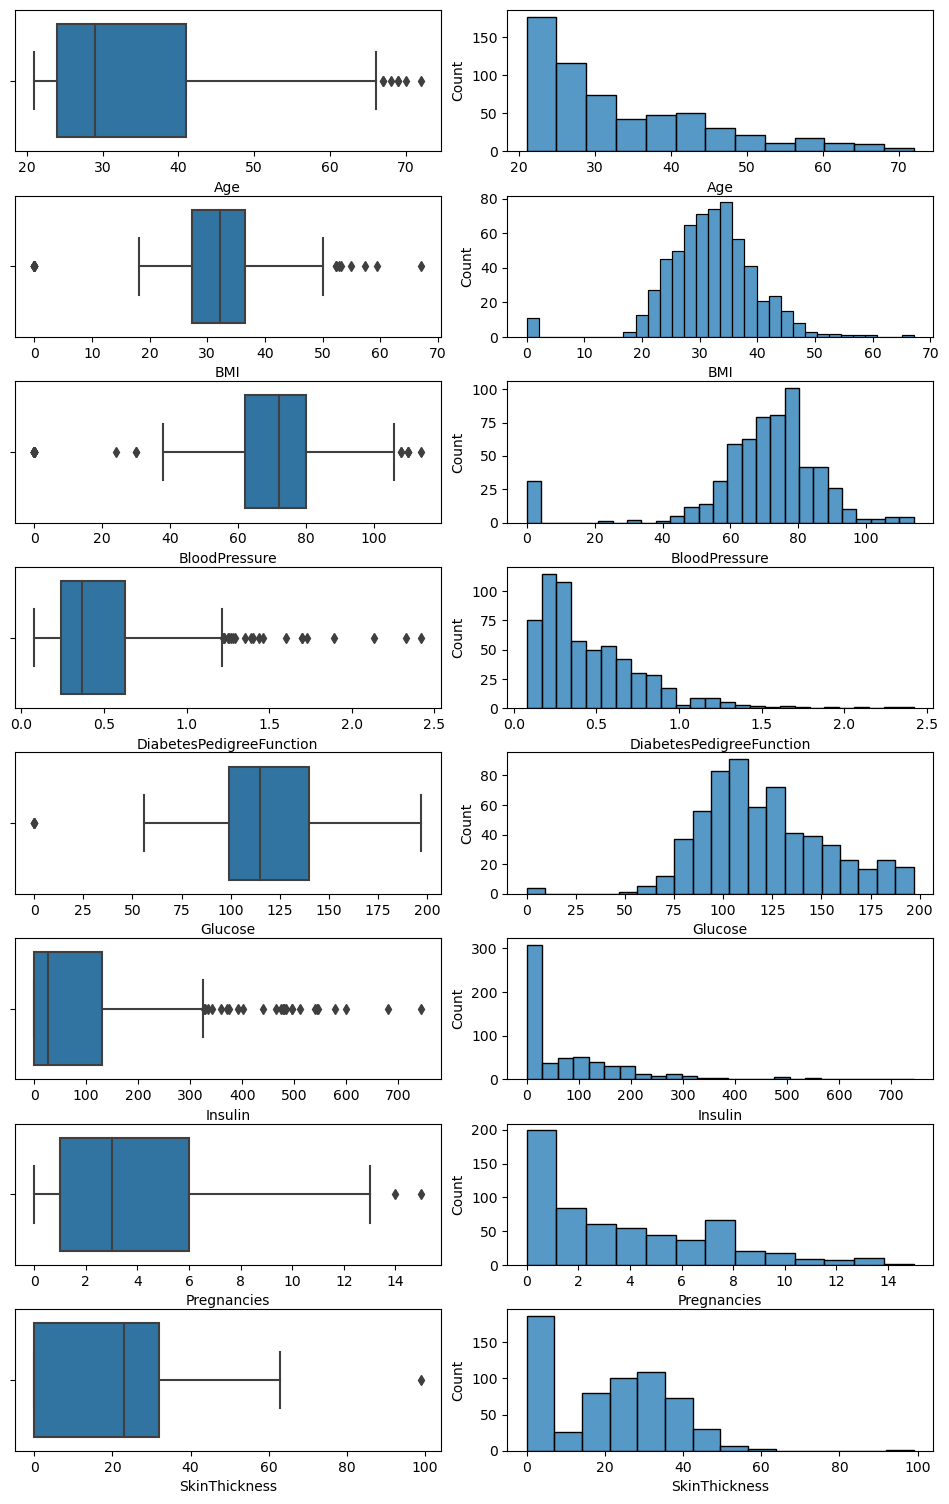

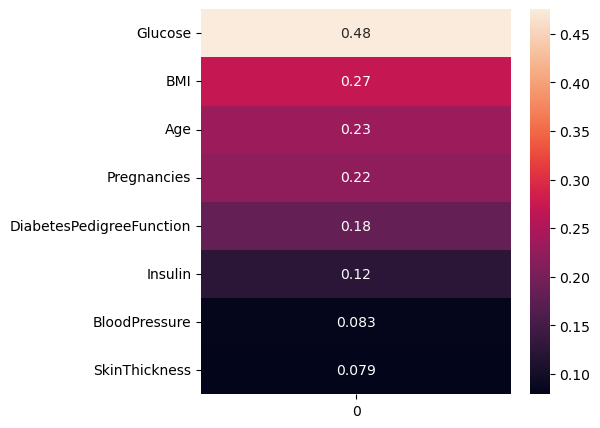

In [9]:
eda.analyze_data(df)

## Voldoet de data aan de voorwaarden voor machine learning?
De data voldoet aan de voorwaarden aangezien de data:
- In een dataframe staat
- Geen lege waardes bevat
- In numerieke waardes is beschreven

## Data opschonen
Echter vinden wij dat de data nog schoongemaakt kan worden, dit vinden wij omdat in de boxplots te zien valt dat de volgende kolommen nog waardes van 0 bevatten die niet mogelijk zouden moeten zijn.
- Glucose
- BMI
- BloodPressure
- Insulin
- SkinThickness

Deze waardes met 0 gaan wij uit de data verwijderen.

Ook zien we dat er veel uitschieters zijn, wij vinden het belangrijk om deze data alsnog mee te nemen aangezien wij denken dat dit wellicht komt door omstandigheden die ook kunnen bijdragen aan diabetes.

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_valid,SkinThickness_valid
0,668,0.649,-0.768,-1.182,0.727,0.870,0.209,-0.124,0.814,0,0.918,0.602
1,324,-0.541,-0.312,0.198,0.664,-0.728,0.454,-0.980,-1.048,0,-1.089,0.602
2,624,-0.541,-0.442,-0.695,-1.357,-0.728,-0.253,-0.950,-1.048,0,-1.089,-1.661
3,690,1.244,-0.475,0.605,-1.357,-0.728,-1.148,1.169,0.052,0,-1.089,-1.661
4,473,0.947,0.469,1.417,-1.357,-0.728,-0.383,-0.792,1.406,0,-1.089,-1.661


,count,mean,std,min,25%,50%,75%,max,dtype
Age,575.0,2.719e-16,1.001,-1.048,-0.794,-0.371,0.645,3.098,float64
BMI,575.0,-3.290e-16,1.001,-2.071,-0.715,-0.022,0.584,4.986,float64
BloodPressure,575.0,2.719e-16,1.001,-3.944,-0.695,-0.045,0.605,3.366,float64
DiabetesPedigreeFunction,575.0,1.406e-16,1.001,-1.193,-0.704,-0.303,0.500,5.917,float64
Glucose,575.0,1.452e-16,1.001,-2.135,-0.703,-0.182,0.665,2.455,float64
Insulin,575.0,-1.236e-17,1.001,-0.728,-0.728,-0.325,0.408,5.532,float64
Insulin_valid,575.0,-7.414e-17,1.001,-1.089,-1.089,0.918,0.918,0.918,float64
Pregnancies,575.0,6.488e-17,1.001,-1.137,-0.839,-0.244,0.649,3.328,float64
SkinThickness,575.0,-1.081e-16,1.001,-1.357,-1.357,0.159,0.727,4.896,float64
SkinThickness_valid,575.0,-8.032e-17,1.001,-1.661,-1.661,0.602,0.602,0.602,float64


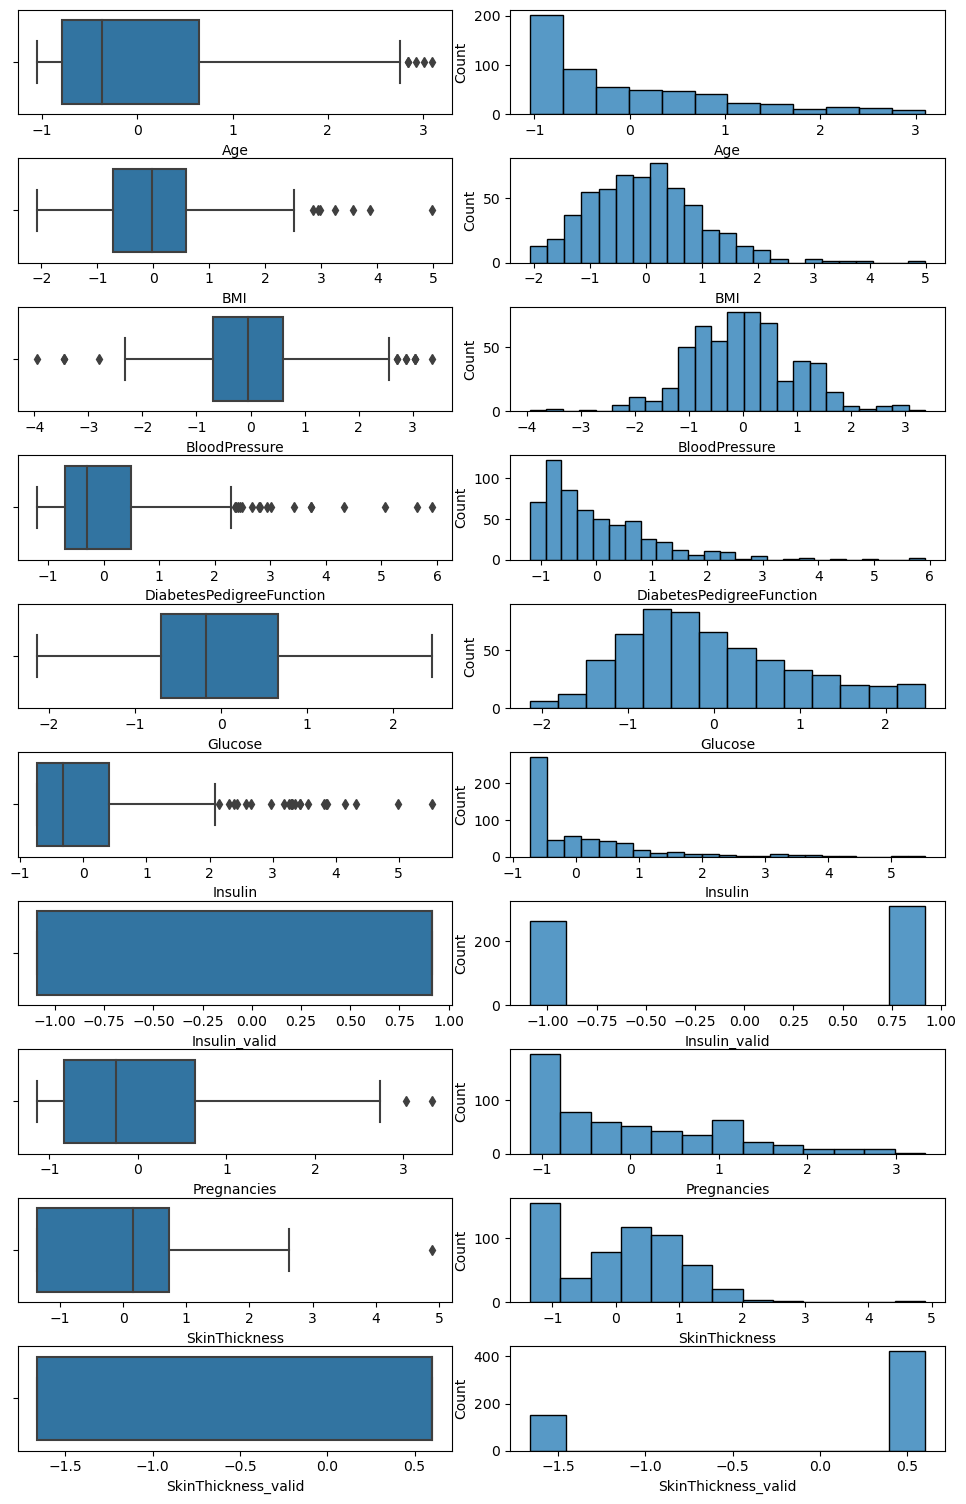

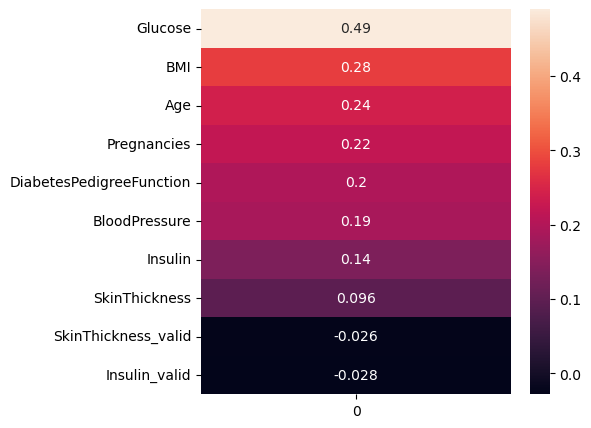

In [10]:
test_df = pd.read_csv('test_c.csv')
cleaned_df = eda.clean_data(df, standardise=True)
cleaned_test_df = eda.clean_data(test_df, standardise=True, is_test_set=True)
eda.analyze_data(cleaned_df)

## Opvallende dingen over opgeschoonde data
We zien dat de data van 614 rijen naar 312 rijen is gegaan, dit betekent dat wij een hoop rijen hebben verwijderd. Echter vinden wij dat dit beter is dan het alternatief, aangezien wij geen vertrouwen hebben goede modellen te kunnen maken als we geen goede data invoeren in de modellen. Zoals het beroemde gezegde "Garbage in = garbage out". 

We zien ook dat de correlaties omhoog zijn gegaan en dit is een goede indicatie dat de data die nu verwijderd is geen goede weergave gaf van de realiteit.

## Standaardiseren
Het staandaardiseren van data houdt in dat je de data schaalt op een manier dat het gemiddelde 0 wordt en de standaard deviatie 1. Om dit te doen wordt het aangeraden om data te hebben wat in een bell-curve valt en dat niet teveel outliers heeft. Ook is het alleen nuttig als feature kolommen ver uit elkaar liggen qua grootte van de waardes. Dit wordt gedaan om verschillende machine learning modellen beter te kunnen trainen als deze kijken naar afstand tussen datapunten om beslissingen te maken (zoals KNN of SVM).

Hoewel wij wel grote waardeverschillen hebben tussen de feature en KNN gebruiken om missende waardes in te vullen hebben wij toch besloten om niet de data te standaardiseren

# Evaluatie

### Deze opdracht heeft betrekking op een bepaalde vorm van machine learning. Welke vorm is dit? Licht het antwoord toe.


Tijdens de opdracht maken wij gebruik van de datasets genaamd "train_c.csv" en "test_c.csv".
Vanuit de opdracht omschrijving is te achterhalen dat we bij "train_c.csv" met een gelabelde dataset te maken hebben. De kolom "Outcome" is meegegeven en dit is in onze modellen dan ook de target kolom. Verder zijn alle overige kolommen ook gelabeld, dit zijn de feuture kolommen.
Ook wordt er gesproken over onze dataset "test_c.csv". Dit is de niet gelabelde dataset waarvoor wij uiteindelijk voorspellingen gaan maken aan de hand van onze modellen. 
https://brightspace.hhs.nl/d2l/le/lessons/56591/topics/663651

Door deze observaties kunnen wij ervan uit gaan dat wij te maken hebben met supervised machine learning. Hierbij worden modellen getraind met behulp van gelabelde datasets. Dit is data waar van te voren de juiste target uitkomst aan is gekoppeld. Met deze data gaat het model voorspellingen doen op niet gelabelde data.
https://www.breinstein.nl/de-digitale-wereld/een-introductie-in-machine-learning/
https://www.ibm.com/topics/supervised-learning




### Geef aan met welke “metrics”, voor deze vorm van machine learning, bepaalt kan worden hoe goed een model presteert. Toon de uitkomsten op deze metrics aan de hand van een zelf te kiezen machine learning algoritme.



Binnen supervised learning zijn er twee verschillende takken, zo is er regressie en classificatie. Bij regressie wordt aan de hand input data een waarde voorspelt. Bij classificatie wordt er voorspelt welk class label bij de input data hoort.
https://datasciencepartners.nl/supervised-learning/

In het geval van diabetes voorspellen is de waarde True of False. Dit geeft aan of iemand wel of niet diabetes heeft. Hier is er sprake van classificatie. Tijdens de opdracht zal er gewerkt worden met classificatie modellen.

Er zijn verschillende manieren om de prestaties van een classificatie model te presenteren, die manieren worden metrics genoemd. Voor classificatie gebruiken wij de volgende metrics:

Accuracy

Precision

Recall

F1-score

De uitkomsten van de bovenstaande metrics worden onder deze markdown cel getoond. Er is gebruik gemaakt van LogisticRegression voor de voorspellingen en een confusion matrix display om de uitkomsten te tonen.

Nu de eenheden duidelijk zijn zullen de verschillende metrics en hun formules hieronder worden toegelicht.

## Accuracy:
Bij accuracy wordt er gemeten hoe vaak het classificatie model een correcte voorspelling heeft gemaakt. Hierbij wordt de som van het aantal correcte voorspellingen gedeeld door de som van het totaal aantal voorspellingen.

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/

## Precision:
Bij precison wordt er gemeten hoeveel correct voorspelde positieven er zijn ten opzichten van het totale aantal voorspelde positieven in de input data. Dit wordt gedaan door de True Positive te delen door de som van True Positive en False Positive. Wanneer het model goed preseteert zal het weinig False Positives bevatten en ligt de precision score dichter bij 1.0.

$Precision = \frac{TP}{TP+FP}$

## Recall:
Bij recall meten we het aantal True Positives gedeeld door de som van de True Positives en False Negatives. Hiermee worden alle correct voorspelde waarden gedeeld door alle  echte correcte waarden in de input data. Zo kan er gemeten worden hoe goed het model presteerd op het gebied van correcte voorspellingen maken aan de hand van de input data.


$Recall = \frac{TP}{TP+FN}$

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

## F1 Score:
De F1 score wordt vaak gebruikt om de nauwkeurigheid van een classificatie model te beoordelen. Dit wordt vaak gedaan wanneer de dataset niet gebalanceerd is. Bij het berekenen van de F1 Score wordt zowel precision als recall gebruikt om het harmonische gemiddelde tussen de twee te berekenen. 

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$




In [18]:
class Machine_learner:
    def __init__(self, df, test_set):
        self.df_handler = DfHandler()
        
        self.df = df
        self.test_df = test_set
        
        self.pred = pd.DataFrame(self.test_df['p_id'])
        
        self.feature_cols = df.columns.difference(["p_id", "Outcome"])
        self.target_col = "Outcome"
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df[self.feature_cols],
                                                                                self.df[self.target_col],
                                                                                train_size = 0.2)
        
        
    def Lr(self):
        model = LogisticRegression()
        
        parameters = [{'solver' : ['newton-cg', 'lbfgs'],
                       'penalty' : ['l2'],
                       'max_iter' : [100, 150, 200, 500, 1000, 2500],
                       'C' : [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 1], 
                       'n_jobs': [-1]},
                      {'solver' : ['liblinear'],
                       'penalty' : ['l1', 'l2'],
                       'max_iter' : [100, 150, 200, 500, 1000, 2500],
                       'C' : [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 1]}]
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def decision_tree(self):
        model = DecisionTreeClassifier()
        
        parameters = {'criterion' : ['gini', 'entropy'],
                      'max_depth': range(3, 8),
                      'min_samples_split': [4, 5, 6],
                      'min_samples_leaf': [4, 5, 6]}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def random_forest(self):
        model = RandomForestClassifier()
        
        parameters = {'n_estimators': range(50, 100, 25),
                      'criterion': ['gini', 'entropy'],
                      'max_depth': range(2, 4),
                      'min_samples_split': [4, 5, 6],
                      'min_samples_leaf': [4, 5, 6],
                      'n_jobs': [-1]}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def gradient_boosting(self):
        model = GradientBoostingClassifier()
        
        parameters = {'n_estimators': range(5, 30, 5),
                      'learning_rate': np.arange(0.05, 0.15, 0.05),
                      'min_samples_split': [4, 5, 6],
                      'min_samples_leaf': [4, 5, 6]}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def ada_boosting(self):
        model = AdaBoostClassifier()
        
        parameters = {'n_estimators': range(10, 25, 5),
                      'learning_rate': np.arange(0.5, 1, 0.1)}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def svm(self):
        model = SVC()
        
        parameters = {'C': [0.1, 1, 10],
                      'kernel': ['linear', 'rbf', 'poly'],
                      'degree': [2, 3, 4],
                      'coef0': [0.0, 0.1, 0.5],
                      'shrinking': [True, False],
                      'class_weight': [None, 'balanced'],
                      'probability': [True, False],
                      'tol': [1e-4, 1e-3, 1e-2]}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def xgboost(self):
        model = XGBClassifier()
        
        parameters = {'n_jobs': [-1],
                      'n_estimators': range(5, 30, 5),
                      'max_depth': range(2, 3),
                      'max_leaves': range(2, 4),
                      'learning_rate': np.arange(0.2, 0.4, 0.1),
                      'max_delta_step': np.arange(0.2, 0.4, 0.1),
                      'gamma': np.arange(0.2, 1, .1)}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def fit(self, clf):
        clf.fit(self.X_train, self.y_train)
        
        train_y_pred = clf.predict(self.X_train)
        test_y_pred = clf.predict(self.X_test)
        f1_train = f1_score(self.y_train, train_y_pred)
        f1_test = f1_score(self.y_test, test_y_pred)
        
        relevant_score_cols = ['params','std_test_score', 'mean_test_score',  'rank_test_score']
        
        display(pd.DataFrame(clf.cv_results_)[relevant_score_cols].sort_values('rank_test_score').head(10))
        display(clf.best_estimator_)
        display(f'Training F1 score: {round(f1_train, 3)}')
        display(f'Testing F1 score: {round(f1_test, 3)}')
        return clf
    
    def make_predictions(self, clf, name):
        clf = ml.fit(clf)
        self.pred['Outcome'] = clf.predict(test_df[self.feature_cols])
        self.pred.to_csv(name + '_prediction.csv', index=False)


In [19]:
ml = Machine_learner(cleaned_df, cleaned_test_df)

# Logistic Regression:
## uitleg model:
Logistic regression is een supervised machine learning model dat wordt gebruikt voor het voorspellen van een binaire uitkomst. Dit betekent dat het model een 0 of 1 voorspelt, is de uitkomst waar of niet waar, True of False.

Logistic regression probeert een lijn(decision boundary) te trekken door de data, om dit te verdelen. Aan de ene kant van de decision boundary wordt de voorspelling 1 en aan de andere kant wordt het 0. Deze decision boundary wordt gevormd door alle features een gewicht mee te geven en deze bij elkaar op te tellen in een formule en een beginpunt toe te voegen. 

Dit is dus praktisch gezien een N-dimensionale lineaire functie met N als hoeveelheid features in de dataset.

De hierboven beschreven decision boundary ziet er als volgt uit:<br>
$z = w_1\cdot x_1+w_2\cdot x_2+ w_3\cdot x_3+\ldots+w_n\cdot x_n + a = 0$<br>
met:<br>
$z = de\ decision\ boundary$<br>
$x_0,x_1,\ldots,x_n = de\ waardes\ van\ de\ features\ om\ de\ decision\ boundary\ 0\ te\ laten\ zijn$<br>
$w_0,w_1,\ldots,w_n = coefficienten\ bepaald\ door\ het\ model$<br>
$a = beginpunt\ bepaald\ door\ het\ model$<br>

Hieronder een voorbeeld van hoe een decision boundary eruit kan zien van een getrained model voor de features $x_1\ en\ x_2$:
![decision boundary](https://scipython.com/static/media/uploads/blog/logistic_regression/decision-boundary.png)

Maar als je deze formule gebruikt kan je nog niet bepalen of een waarde 0 of 1 moet worden, Daarom wordt deze functie in een sigmoid functie gezet. Een sigmoid functie is een functie die eruit ziet als s-curve, aan de linkerkant van de y-as ligt deze functie erg dicht bij y=0 en stijgt dan steeds sneller naarmate x=0 nadert. Dan kruist de functie y=0.5 bij x=0 en vlakt dan langzaam weer af wanneer de lijn y=1 nadert. Je kan de uitkomst van de lijn zien als zekerheid van het model of de waarde als 1 voorspelt zou moeten worden. Als de zekerheid boven de 0.5 ligt dan voorspelt het model 1 en als het onder de 0.5 ligt dan voorspelt het model 0. Als een punt precies op de decision boundary ligt zal de voorspelde waarde dus ook 0.5 zijn.

De hierboven beschreven sigmoid functie ziet er als volgt uit:<br>
$\hat{y} = \frac{1}{1+e^{-z}}$<br>
met:<br>
$\hat{y} = de\ voorspelde\ zekerheid$<br>
$e = euler's\ nummer\ = 2.718...$<br>
$z = de\ formule\ van\ de\ decision\ boundary$<br>


Hier een visualisatie van de sigmoid functie:
![sigmoid functie](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/800px-Logistic-curve.svg.png)

En als je hier dan de door het model gegenereerde waardes van de coefficienten en het beginpunt invult in de formule van de decision boundary en de waardes van de features van de rij uit je dataset die je wilt voorspellen dan komt er een waarde tussen de 0 en 1 uit. Waarbij alle waardes tussen 0 en 0.5 geclassifiseerd worden als 0 en alle waardes tussen 0.5 en 1 geclassifiseerd worden als 1.
## loss function:
Om te kijken hoe goed het model werkt wordt de loss functie toegepast. Deze functie neemt de echte waarde en de voorspelde zekerheid en gebruikt deze in een formule om zo te kijken hoe goed het model is. Dit kan op verschillende manieren gedaan worden, maar bij logistic regression is het gebruikelijk om de log loss functie toe te passen.

De hierboven genoemde log loss functie ziet er als volgt uit:<br>
$-\frac{1}{n}\displaystyle\sum_{i=1}^{n}(y_i\cdot log(\hat{y_i})+(1-y_i)\cdot log(1-\hat{y_i}))$<br>
Met:<br>
$n = Hoeveelheid\ voorspelde\ datapunten$<br>
$y_i = De\ echte\ waarde\ van\ het\ i^{de}\ datapunt$<br>
$\hat{y_i} = De\ voorspelde\ zekerheid\ van\ het\ i^{de}\ datapunt$<br>

Deze formule is eigenlijk 2 formules in 1.

zo wordt bij een echte waarde van 0 alleen de rechterzijde van de formule gebruikt aangezien:
$-\frac{1}{n}\displaystyle\sum_{i=1}^{n}(0\cdot log(\hat{y_i})+(1-0)\cdot log(1-\hat{y_i})) = -\frac{1}{n}\displaystyle\sum_{i=1}^{n}(log(1-\hat{y_i}))$<br>
En bij een echte waarde van 1 wordt alleen de linkerzijde gebruikt aangezien:<br>
$-\frac{1}{n}\displaystyle\sum_{i=1}^{n}(1\cdot log(\hat{y_i})+(1-1)\cdot log(1-\hat{y_i})) = -\frac{1}{n}\displaystyle\sum_{i=1}^{n}(log(\hat{y_i}))$<br>
![log loss](https://editor.analyticsvidhya.com/uploads/661483.png)
De grafiek van de log loss functie is hierboven weergegeven met $\hat{y_i}=h(x)$.

Je kan in de visualisatie goed zien dat de loss steeds verder toeneemt naarmate de voorspelde waarde verder van de echte waarde ligt. Ook kan je goed zien waarom log loss zo goed werkt voor binaire classificatie aangezien het werkt voor 0 en 1 tegelijk.

## gradient descent:
Om de hierboven beschreven loss zo klein mogelijk te maken moeten de coefficienten en het beginpunt van de decision boundary worden bepaald. Dit gebeurd met een proces genaamd gradient descent, gradient descent probeert de loss naar een minimum te brengen voor alle coefficienten.

Dit gebeurt door de helling te berekenen van de loss functie tegenover de leerbare coefficient. als de helling namelijk 0 is betekent dit dat we een minimum hebben bereikt.

De formule van het updaten van de coefficient ziet er als volgt uit:<br>
$w_{i_{nieuw}} = w_{i_{oud}}-\alpha \cdot \frac{\delta Loss}{\delta w}$<br>
Met:<br>
$w_{i_{nieuw}} = De\ nieuwe\ waarde\ voor\ de\ i^{de}\ coefficient\ w$<br>
$w_{i_{oud}} = De\ oude\ waarde\ voor\ de\ i^{de}\ coefficient\ w$<br>
$\alpha = de\ learning\ rate$<br>
$\frac{\delta Loss}{\delta w} = De\ coefficient\ van\ de\ helling\ van\ de\ loss\ tegenover\ w$<br>

Gradient descent blijft de coefficienten updaten tot deze onder een bepaalde threshold komen, 0 bereiken of als de maximale hoeveelheid updates(stappen) bereikt is. Gradient descent pakt een punt en kijkt hoe groot de helling is, vervolgens wordt er een stap gezet proportioneel aan de grote van de coefficient van de helling. Al is er dus een stijle helling die een daling ondervind naar een richting word er ook een grote stap naar die richting gezet om daar vervolgens te kijken hoe de helling daar is. Dit zou moeten leiden naar een punt waar de helling minder stijl is. Dus als er vervolgens een kleinere helling wordt gevonden betekent dit dat we dichterbij de optimale waarde van w zijn en wordt er maar een kleine stap gezet richting de daling van de helling.

Dit ziet gevisualiseerd als volgt uit:
![gradient descent](https://www.researchgate.net/profile/Kamyab-Keshtkar/publication/355179987/figure/fig6/AS:1078354740555780@1634111213342/A-schematic-representation-of-the-gradient-descent-algorithm-The-gradient-of-the-loss.png)

Ook bevat de formule de term $\alpha$, dit is de learning rate. De learning rate is een hyperparameter die gebruikt kan worden om te beinvloeden hoe groot de stappen zijn die gezet worden door de gradient descent. Bij een kleine learning rate worden er dus kleine stappen gezet, hierdoor duurt het langer om bij het minimum te komen, maar het kan hierdoor ook nauwkeuriger worden. Bij een grote learning rate worden er dus grote stappen gezet, maar is hierdoor dus ook minder nauwkeurig. Het is van belang dat er de learning rate zo gekozen wordt dat de training in realistische tijd kan worden uitgevoerd. Ook is het gevaarlijk om te precies het minimum te willen bereiken met de trainingsdata, dit zorgt er namelijk voor dat je model overfit en dat kan leiden tot een geweldige score bij je trainingsdata maar een slechte score bij je test data.

Hieronder een visualisatie van de learning rate met betreffing tot hoe het de stappen van gradient descent beinvloeden:
![learning rate](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/gradient-descent-learning-rate.png)
## regularisatie:
Regularisatie is een manier om overfitting van een model tegen te gaan, dit wordt gedaan door een penalty gebaseerd op de coefficienten van de decision boundary toe te voegen aan de loss functie. Hierdoor worden grote coefficienten afgestraft en wordt het model beter in generaliseren.

Er zijn 2 types regularizatie die vaak worden toegepast, namelijk L1/Lasso regularizatie en L2/Ridge regularizatie:

De formules hiervoor zien er als volgt uit:<br>
$L1 = \frac{1}{c}\displaystyle\sum_{i=1}^{n}|w_i|$<br>
$L2 = \frac{1}{c}\displaystyle\sum_{i=1}^{n}w_i^2$<br>
Met:<br>
$c = Een\ hyperparameter\ die\ de\ sterkte\ van\ de\ regularizatie\ beinvloed$<br>
$n = Hoeveelheid\ coefficienten$<br>
$w_i = De\ i^{de}\ coefficient$<br>

Zoals hier te zien wordt er bij L1 simpelweg de som van de absolute waarde van de coefficienten toegevoegd en bij L2 de som van het kwadraat van de coefficienten. 

Door het verschil in de formules van L1 en L2 zijn er ook een aantal verschillen in het gebruik van de verschillende regularizaties. 

Zo kan L1 worden gebruikt voor feature selecting aangezien het mogelijk is voor L1 om coefficienten naar 0 te kunnen brengen. Zodra een coefficiente van een feature op 0 staat wordt deze feature dus niet meer meegenomen in de voorspelling. Dit komt doordat de helling van de grafiek van L1 regularisatie bij 0 undefined is wat zorgt dat de gradient descent voor die feature ophoudt. Terwijl bij L2 regularisatie de helling bij de waarde 0 voor de coefficient simpelweg ook 0 is dus zal de gradient descent gewoon doorgaan en is het heel onwaarschijnlijk dat de waarde eindigt op 0.

In de grafiek hieronder zie je hoe de helling tegelijk 1 en -1 is bij een coefficient van 0 wat zorgt dat de gradient descent stopt met werken en de feature op 0 blijft staan.
![feature selecting with L1](https://miro.medium.com/v2/resize:fit:1400/1*etUdoAT3P51qjMiadDRHhQ.gif)

Ook valt te zien dat L1 regularisatie de coefficient meer afstraft als deze zich tussen -1 en 1 bevind terwijl L2 regularisatie de coefficient meer afstraft als deze groter is dan 1 of kleiner dan -1.

## Toepassing en tuning:
Het tunen van de hyperparameters doen wij doormiddel van GridSearchCV uit de sklearn library, deze functie fit de data doormiddel van cross-validation en kijkt welke hyperparameters het beste werken.
De parameters die wij testen zijn:
- solver
- penalty
- maximum iterations
- c

Wij hebben hierboven uitgelegd wat de basis is van het optimaliseren van de coefficienten doormiddel van gradient descent. Maar in de realiteit zijn er veel kleine(en soms grote) verschillen in hoe dit daadwerkelijk geimplementeerd word(soms met andere methodes dan gradient descent). De solver parameter is een manier om te kiezen tussen de manieren die worden aangeboden in de sklearn library.

Ook hebben wij regularisatie uitgelegd hierboven, de parameter penalty geeft aan welke regularisatie er gebruikt moet worden. Niet alle solvers zijn compatibel met alle regularisaties, maar toch testen wij alle mogelijke combinaties met de solvers die wij gekozen hebben en de regularisatie die hierbij toegepast kunnen worden. Dit om overfitting zoveel mogelijk tegen te gaan.

Maximum iterations geeft aan na hoeveel stappen de solver moet stoppen met het optimaliseren van de coefficienten, dit om overfitting tegen te gaan. Zoals hierboven ook al beschreven bij gradient descent onder learning rate is het van belang niet het perfecte minimum te bereiken voor je training data aangezien het waarschijnlijk is dat je model dan overfit is en niet goed kan generaliseren op nieuwe data. Door maximale iterations aan te passen kan de solver niet oneindig doorgaan om het minimum te zoeken en zal het model dus minder overfit raken.

c is in dit geval dezelfde c als gebruikt in de regularisatie formule, door het aanpassen van deze c kunnen wij controleren hoe sterk de regularisatie is en daarmee kunnen we proberen het model mooi te laten generaliseren zonder te overfitten.

Ook zie je n_jobs staan in de parameters van GridSearchCV, dit heeft verder geen impact op het model, maar is alleen om te zorgen dat alle cores van de processor worden gebruikt om zo sneller te kunnen trainen.

Bij het tunen hebben wij vele waardes geprobeerd en gekeken of deze voor goede resultaten zorgen. De waardes die overgebleven zijn, zijn de waardes die zorgen dat het model in ieder geval niet teveel overfit. Dit hebben wij bepaald door de F1 score van de trainingsdata en de testdata te vergelijken en te zorgen dat hier een niet al te hoog verschil in zit.

In [21]:
ml.make_predictions(ml.Lr(), 'lr')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,params,std_test_score,mean_test_score,rank_test_score
154,"{'C': 0.05, 'max_iter': 2500, 'penalty': 'l1', 'solver': 'liblinear'}",0.064,0.774,1
50,"{'C': 0.075, 'max_iter': 150, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.089,0.774,1
51,"{'C': 0.075, 'max_iter': 150, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.089,0.774,1
52,"{'C': 0.075, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.089,0.774,1
53,"{'C': 0.075, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.089,0.774,1
54,"{'C': 0.075, 'max_iter': 500, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.089,0.774,1
55,"{'C': 0.075, 'max_iter': 500, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.089,0.774,1
56,"{'C': 0.075, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.089,0.774,1
57,"{'C': 0.075, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.089,0.774,1
58,"{'C': 0.075, 'max_iter': 2500, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.089,0.774,1


LogisticRegression(C=0.075, n_jobs=-1, solver='newton-cg')

'Training F1 score: 0.704'

'Testing F1 score: 0.605'

# Decision Tree:
## uitleg model:
## splitsingscriteria:
## toepassing en tuning:
## pruning:

In [ ]:
ml.make_predictions(ml.decision_tree(), 'decision_tree')

# Random Forest:
## uitleg model:
## performance en pruning:
## toepassing en tuning:

In [ ]:
ml.make_predictions(ml.random_forest(), 'random_forest')

# Gradient Boosting:
## uitleg model:
## performance en pruning:
## toepassing en tuning:

In [ ]:
ml.make_predictions(ml.gradient_boosting(), 'gradient_boost')

# ADA Boosting:
## uitleg model:
## toepassing en tuning:

In [ ]:
ml.make_predictions(ml.ada_boosting(), 'ada_boost')

# Support Vector Machines:
## uitleg model:
## kernel trick:
## loss functie:
## regularisatie:
## toepassing en tuning:

In [ ]:
ml.make_predictions(ml.fit(ml.svm(), 'svm')

# XGBoost (Eigen model):
## uitleg model:
## toepassing en tuning:

In [ ]:
ml.make_predictions(ml.xgboost(), 'XGboost')

# Ensemble:
## uitleg en voting:
## toepassing en tuning: